# Colab command

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/build_model/TrainValidate.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_features_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_labels_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_sources_removed.csv /content
!cp /content/drive/MyDrive/all_removed_weighted_sampler_full_epoch_1000_fold_2.pth /content
!mkdir /content/models

In [ ]:
!pip install --quiet torchinfo
!pip install --quiet torch_snippets

# Import packages

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

import torchinfo
from torch_snippets import Report
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from TrainValidate import TrainValidate, create_weighted_sampler

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"

In [4]:
device

'mps'

# Append predicted to features
## The model

In [5]:
class PredictPrice(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

        self.hidden = nn.Sequential(nn.Linear(in_features, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 128),
                                    nn.ReLU())
        self.price = nn.Sequential(nn.Linear(128, 1),
                                   nn.ReLU())

    def forward(self, x):
        x = self.hidden(x)
        price = self.price(x)
        return price.squeeze()

## Load datasets

In [6]:
features = pd.read_csv("../datasets/final_features_removed.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")
sources = pd.read_csv("../datasets/final_sources_removed.csv")

## Data standardization

In [7]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

## Predict prices

In [8]:
filename = "models/all_removed_weighted_sampler_full_epoch_1000_fold_2.pth"
model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()

prices = []
for i in range(len(features)):
    feature = torch.tensor((features.iloc[i])).float()
    pred_price = model(feature)
    prices.append(pred_price.detach().item())

pred = pd.DataFrame({"PredictPrice": prices, "Price": labels["Price / Rent"]})

In [23]:
features = pd.read_csv("../datasets/final_features_removed.csv")
features["Predict Price"] = pred["PredictPrice"]
features["Actual Price"] = labels["Price / Rent"]
features.to_csv("../datasets/final_features_prices.csv", index=False)

In [24]:
features["Status"] = labels["Completed"]
features

,Postcode,Sale or Let,Price Qualifier,DESC Council Tax Band,RTD3316_condition1 - Condition Description,# of Enquiry or viewings,# of Apps/Offers,bedroom number,kitchen number,living number,...,Gas,Gas Central,Night Storage,Oil,Solar,Solar Water,Under Floor,Predict Price,Actual Price,Status
0,3610,0,3,1,1,0.0,6.0,2,1,1,...,0,1,0,0,0,0,0,625.755737,600.0,1
1,3647,1,7,3,1,0.0,4.0,3,1,0,...,0,1,0,0,0,0,0,389552.875000,380000.0,1
2,3650,1,7,4,1,0.0,1.0,4,1,0,...,0,1,0,0,0,0,0,474756.718750,475000.0,1
3,3620,0,3,0,1,0.0,7.0,2,1,1,...,0,1,0,0,0,0,0,733.294800,625.0,1
4,3596,0,3,1,1,0.0,3.0,3,1,1,...,0,1,0,0,0,0,0,880.092651,695.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8990,4476,0,3,3,1,0.0,0.0,3,1,2,...,0,1,0,0,0,0,0,769.316284,1200.0,0
8991,4443,1,6,3,1,0.0,1.0,3,1,1,...,0,1,0,0,0,0,0,334037.187500,340000.0,1
8992,4458,1,6,5,1,0.0,0.0,4,1,0,...,1,1,0,0,0,0,0,449794.281250,450000.0,0
8993,547,0,3,0,1,0.0,2.0,1,1,0,...,1,1,0,0,0,0,0,689.302612,750.0,1


# Correlations

In [25]:
corr = features.corr()
corr

,Postcode,Sale or Let,Price Qualifier,DESC Council Tax Band,RTD3316_condition1 - Condition Description,# of Enquiry or viewings,# of Apps/Offers,bedroom number,kitchen number,living number,...,Gas,Gas Central,Night Storage,Oil,Solar,Solar Water,Under Floor,Predict Price,Actual Price,Status
Postcode,1.000000,0.046555,0.037082,0.010673,-0.018759,0.001258,0.009171,0.028119,-0.036365,0.039800,...,-0.005584,-0.019210,-0.013877,0.054284,0.000291,0.001006,-0.012071,0.069400,0.064486,0.006489
Sale or Let,0.046555,1.000000,0.415315,0.189002,0.181878,0.068012,-0.061728,0.275907,0.071064,-0.023808,...,0.087576,0.096687,-0.073175,0.039318,0.027269,0.017266,0.013832,0.697056,0.693048,-0.204237
Price Qualifier,0.037082,0.415315,1.000000,-0.023723,0.021448,-0.027678,-0.060535,0.125371,0.044319,-0.011127,...,-0.002148,0.049010,-0.032144,0.012033,0.007202,-0.025530,-0.016929,0.156928,0.153644,-0.066868
DESC Council Tax Band,0.010673,0.189002,-0.023723,1.000000,-0.009086,0.013905,-0.055583,0.571032,0.041790,0.136644,...,-0.019789,0.006731,-0.045675,0.144668,0.069952,0.021519,0.120348,0.603987,0.599903,-0.144287
RTD3316_condition1 - Condition Description,-0.018759,0.181878,0.021448,-0.009086,1.000000,0.014655,0.038127,0.029412,0.026909,0.017905,...,0.016589,-0.022531,-0.009541,0.017853,0.001952,-0.008103,-0.028865,0.063693,0.064331,-0.005398
# of Enquiry or viewings,0.001258,0.068012,-0.027678,0.013905,0.014655,1.000000,0.324345,0.033023,0.009802,0.021419,...,0.008896,0.007266,-0.004854,-0.017254,-0.003644,-0.005631,0.001627,0.088341,0.088134,0.095295
# of Apps/Offers,0.009171,-0.061728,-0.060535,-0.055583,0.038127,0.324345,1.000000,-0.018878,0.009710,0.005956,...,0.036355,0.024583,0.014804,-0.042608,-0.007081,-0.003298,-0.028835,-0.055779,-0.057111,0.233266
bedroom number,0.028119,0.275907,0.125371,0.571032,0.029412,0.033023,-0.018878,1.000000,0.160436,0.056877,...,0.009736,0.160807,-0.088836,0.103969,0.070590,0.011978,0.061716,0.488936,0.482703,-0.082094
kitchen number,-0.036365,0.071064,0.044319,0.041790,0.026909,0.009802,0.009710,0.160436,1.000000,0.070756,...,0.007935,0.042562,0.000694,0.008937,0.023280,0.000163,0.030561,0.073835,0.072990,-0.001663
living number,0.039800,-0.023808,-0.011127,0.136644,0.017905,0.021419,0.005956,0.056877,0.070756,1.000000,...,-0.024416,-0.059735,0.002050,0.031308,0.005292,-0.005385,0.048357,0.100138,0.101534,-0.050986


<AxesSubplot:>

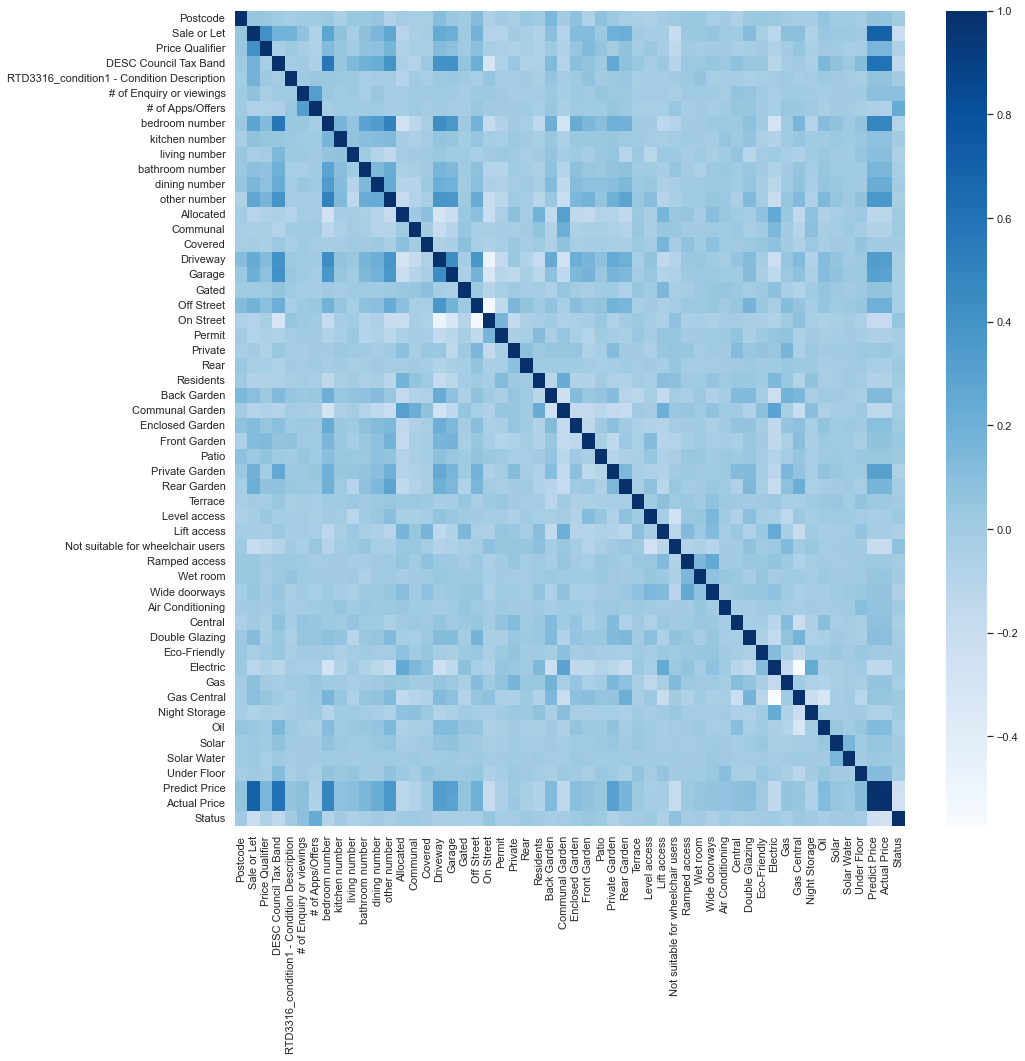

In [26]:
sns.set(font_scale=0.5)
sns.set(rc={'figure.figsize':(15, 15)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="Blues")

# Linear regression models
## Build the model

In [36]:
class PredictStatus(nn.Module):
    def __init__(self, in_features):
        super(PredictStatus, self).__init__()
        self.layer = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.layer(x).squeeze()

In [28]:
model = PredictStatus(53)
torchinfo.summary(model, input_size=(1, 53))

Layer (type:depth-idx)                   Output Shape              Param #
PredictStatus                            --                        --
├─Linear: 1-1                            [1, 1]                    54
Total params: 54
Trainable params: 54
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Prices included
### Class for collecting data

In [37]:
class StatusDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels

    def __getitem__(self, item):
        features = self.features.to_numpy()[item]
        features = torch.tensor(features).float().to(device)

        labels = self.labels.to_numpy()[item]
        price = torch.tensor(labels[0]).float().to(device)

        return features, price

    def __len__(self):
        return len(self.features)

### Load datasets

In [38]:
features = pd.read_csv("../datasets/final_features_prices.csv")

### Data standardization

In [39]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

### Split dataset

In [40]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

In [42]:
temp = StatusDataset(x_train, y_train)
in_features = len(temp[0][0])
in_features

53

### Train the model

In [43]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatusDataset(train_feature, train_label)
    val_data = StatusDataset(val_feature, val_label)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/linear_regression_status_include_full_fold_{}.pth".format(fold))



-------------This is fold 0----------------
EPOCH: 0.129	val_loss: 1.119	(3.81s - 29564.36s remaining)))

KeyboardInterrupt: 

## Price not included
### Load datasets

In [25]:
features = pd.read_csv("../datasets/final_features_removed.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")

In [26]:
temp = StatusDataset(features, labels)
in_features = len(temp[0][0])

### Data standardization

In [27]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

### Split datasets

In [28]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

### Train the model

In [29]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatusDataset(train_feature, train_label)
    val_data = StatusDataset(val_feature, val_label)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/linear_regression_status_exclude_full_fold_{}.pth".format(fold))



-------------This is fold 0----------------
EPOCH: 1.250	train_loss: 1.333	(5.18s - 4135.87s remaining)))

KeyboardInterrupt: 